In [69]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import torch
import os

In [70]:
data_path = r"C:\Users\matth\Desktop\data"
os.chdir(data_path)
dataset = xr.open_dataset('l3_blended_l4_extracts_gR_201701.nc')
dataset

<xarray.Dataset>
Dimensions:       (i: 6064, y: 48, x: 48, s: 2)
Coordinates:
    lat           (i, y) float64 ...
    lon           (i, x) float64 ...
Dimensions without coordinates: i, y, x, s
Data variables: (12/18)
    mta           (i, y, x) float32 ...
    mtb           (i, y, x) float32 ...
    sstL3         (i, y, x) float32 ...
    sstL4         (i, y, x) float32 ...
    usstL4        (i, y, x) float32 ...
    sensitivity   (i) float64 ...
    ...            ...
    corrab        (i) float64 ...
    corr34        (i) float64 ...
    finlier       (i) float64 ...
    time          (i) datetime64[ns] ...
    gRsst         (i, y, x) float32 ...
    day_or_night  (i) object ...

In [71]:
N_data = len(dataset.gRsst)
N_pixels = len(dataset.gRsst.x)

gRsst = dataset.gRsst
sstL4 = dataset.sstL4

### Check Temperature Values
Ensure temperatures are within a physical range (270-310K) i.e. no outliers emerged from data analysis. Find max, min, mean and plot in histogram. 

Text(0.5, 1.0, 'Mean')

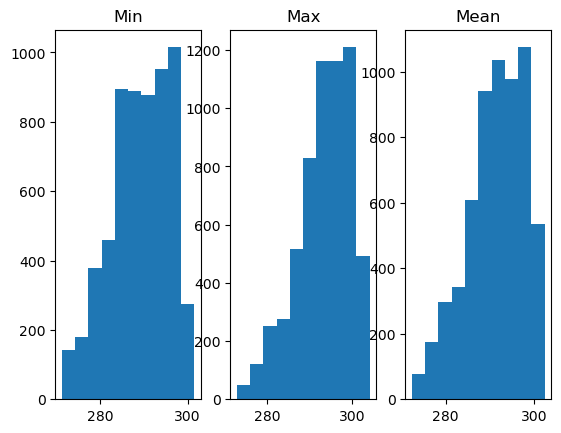

In [72]:
## check temperature values are normal
mean_array = gRsst.mean(dim={'x','y'})
min_array = gRsst.min(dim={'x','y'})
max_array = gRsst.max(dim={'x','y'})
fig, ax = plt.subplots(1,3)
ax[0].hist(min_array)
ax[0].set_title('Min')
ax[1].hist(max_array)
ax[1].set_title('Max')
ax[2].hist(mean_array)
ax[2].set_title('Mean')

### Correlation in absolute field

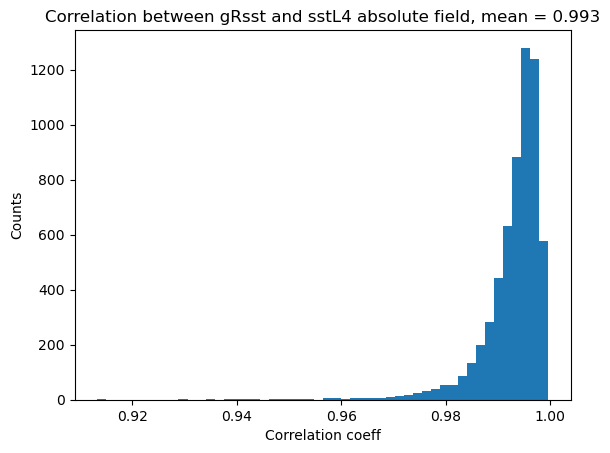

In [157]:
absolute_corr = xr.corr(gRsst, sstL4, dim={'x','y'})
absolute_corr.attrs['units'] = 'PPCC'
plt.hist(absolute_corr.data, bins = 50)
plt.xlabel('Correlation coeff')
plt.ylabel('Counts')
plt.title(f'Correlation between gRsst and sstL4 absolute field, mean = {np.round(absolute_corr.mean().data,3)}')
plt.show()

### Correlation in gradient field

Check

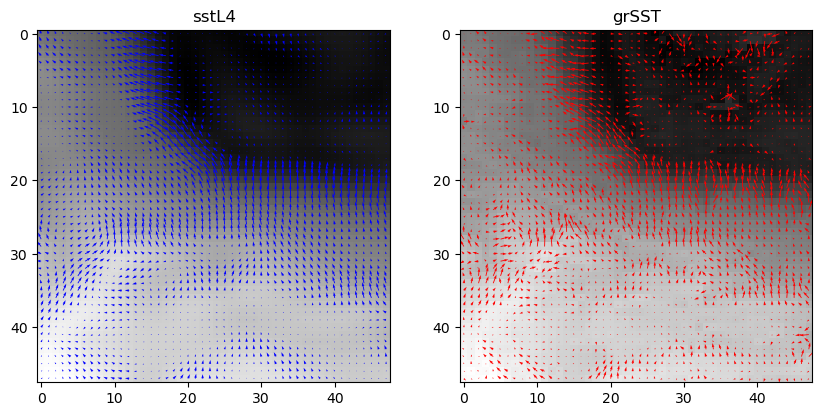

In [138]:
gRsst_x_grad = gRsst.differentiate('x').data
gRsst_y_grad = gRsst.differentiate('y').data
sstL4_x_grad = sstL4.differentiate('x').data
sstL4_y_grad = sstL4.differentiate('y').data
x, y = np.meshgrid(np.arange(0,48,1),np.arange(0,48,1))
fig, ax = plt.subplots(1,2, figsize=(10,10))
i=2
ax[0].quiver(x, y, sstL4_x_grad[i], sstL4_y_grad[i], color='blue')
ax[0].imshow(sstL4[i].data, cmap='gray')
ax[0].set_title('sstL4')
ax[1].quiver(x, y, gRsst_x_grad[i], gRsst_y_grad[i],  color='red')
ax[1].imshow(gRsst[i].data, cmap='gray')
ax[1].set_title('grSST')
plt.show()

In [139]:
gRsst_grad = xr.Dataset({
    "x_grad": gRsst.differentiate('x'),
    "y_grad": gRsst.differentiate('y')})
sstL4_grad = xr.Dataset({
    "x_grad": sstL4.differentiate('x'),
    "y_grad": sstL4.differentiate('y')})
x_grad_corr = xr.corr(gRsst_grad.x_grad, sstL4_grad.x_grad, dim={'x','y'})
y_grad_corr = xr.corr(gRsst_grad.y_grad, sstL4_grad.y_grad, dim={'x','y'})
mean_x = x_grad_corr.mean()
mean_y = y_grad_corr.mean()

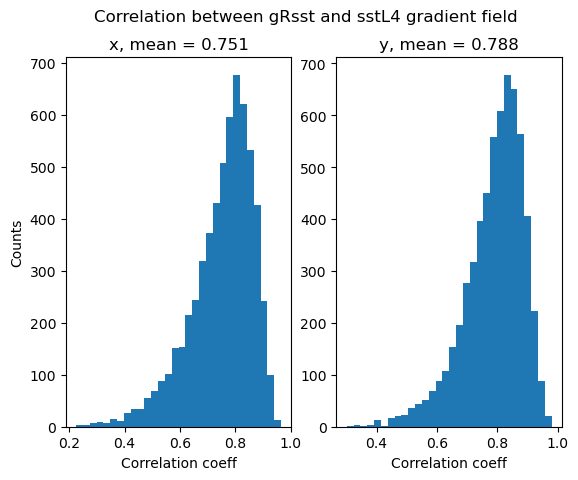

In [155]:
fig, ax = plt.subplots(1,2)
ax[0].hist(x_grad_corr.data, bins = 30) 
ax[0].set_xlabel('Correlation coeff')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'x, mean = {np.round(mean_x.data,3)}')
ax[1].hist(y_grad_corr.data, bins = 30)
ax[1].set_xlabel('Correlation coeff')
ax[1].set_title(f'y, mean = {np.round(mean_y.data,3)}')
fig.suptitle('Correlation between gRsst and sstL4 gradient field')
plt.show()